# **언어 모델링 실습: 트위터 데이터 감정 분석**


## **1. 환경준비**

In [1]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 자연어 처리를 위해 추가된 부분
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm.auto import tqdm
from collections import Counter
import string
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
np.set_printoptions(linewidth=200)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


* 디바이스설정

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

* 딥러닝을 위한 데이터로더 만들기

In [2]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :
    # 데이터 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.long)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    x_val_tensor = torch.tensor(x_val, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    # TensorDataset 생성 : 텐서 데이터셋으로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [3]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset) # 전체 데이터 세트의 크기
    num_batches = len(dataloader) # 배치 크기
    tr_loss = 0

    model.train() # 학습 모드로 설정
    for x, y in dataloader: # 배치 단위로 로딩
        x, y = x.to(device), y.to(device) # 디바이스 지정

        # Feed Forward(오차 순전파)
        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation(오차 역전파)
        loss.backward() # 역전파를 통해 각 파라미터에 대한 오차의 기울기 계산
        optimizer.step() # 옵티마이저가 모델의 파라미터를 업데이트
        optimizer.zero_grad() # 옵티마이저의 기울기값 초기화.

    tr_loss /= num_batches # 모든 배치의 오차 평균
    return tr_loss.item()

* 검증을 위한 함수

In [4]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval() # 모델을 평가 모드로 설정

    with torch.no_grad(): # 평가 과정에서 기울기를 계산하지 않도록 설정
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item() # 예측값 pred와 목푯값 y 사이의 오차 계산

    return eval_loss, pred

* 학습곡선

In [5]:
def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1, len(tr_loss_list)+1)) # 에포크 수 계산
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.') # 학습 오차 그래프
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.') # 검증 오차 그래프
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

* 데이터 로딩

In [ ]:
data = pd.read_csv('https://bit.ly/emotions_csv')
data.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


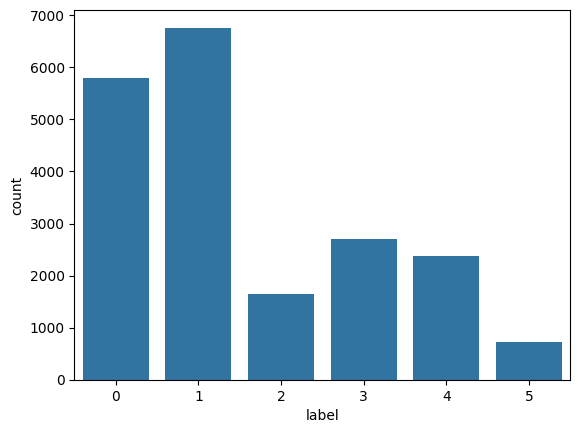

In [ ]:
sns.countplot(x = 'label', data = data)
plt.show()

## **2. 데이터 전처리**

### (1) 토큰화

In [9]:
# 불필요한 단어(Stopwords & 구두점) 집합 준비
stop_words = set(stopwords.words("english"))
punctuations = set(string.punctuation)

# 전처리 함수
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations]
    return tokens

# 데이터에 전처리 함수 적용
data["tokens"] = data["text"].apply(preprocess_text)
data.head()

,text,label,tokens
0,i didnt feel humiliated,0,"[didnt, feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,0,"[go, feeling, hopeless, damned, hopeful, aroun..."
2,im grabbing a minute to post i feel greedy wrong,3,"[im, grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,2,"[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,3,"[feeling, grouchy]"


### (2) Vocab 만들기

In [10]:
all_words = [word for tokens in data["tokens"] for word in tokens]
word_counts = Counter(all_words)
vocab = {word: idx + 1 for idx, (word, _) in enumerate(word_counts.most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = len(vocab)
print(f"어휘 집합 크기: {len(vocab)}")

어휘 집합 크기: 16947


### (3) 정수 인덱스로 변환

* 데이터 전처리

In [11]:
def text_to_sequence(tokens):
    return [vocab.get(word, vocab["<UNK>"]) for word in tokens]
data["sequences"] = data["tokens"].apply(text_to_sequence)
data[["text", "tokens", "sequences"]].head()

,text,tokens,sequences
0,i didnt feel humiliated,"[didnt, feel, humiliated]","[50, 1, 510]"
1,i can go from feeling so hopeless to so damned...,"[go, feeling, hopeless, damned, hopeful, aroun...","[31, 2, 408, 2987, 431, 44, 54, 1565, 1252]"
2,im grabbing a minute to post i feel greedy wrong,"[im, grabbing, minute, post, feel, greedy, wrong]","[4, 2988, 1100, 183, 1, 381, 308]"
3,i am ever feeling nostalgic about the fireplac...,"[ever, feeling, nostalgic, fireplace, know, st...","[78, 2, 561, 4628, 6, 13, 3363]"
4,i am feeling grouchy,"[feeling, grouchy]","[2, 918]"


### (4) 패딩

In [13]:
data["len"] = data["tokens"].apply(len)
data.head()

,text,label,tokens,sequences,len
0,i didnt feel humiliated,0,"[didnt, feel, humiliated]","[50, 1, 510]",3
1,i can go from feeling so hopeless to so damned...,0,"[go, feeling, hopeless, damned, hopeful, aroun...","[31, 2, 408, 2987, 431, 44, 54, 1565, 1252]",9
2,im grabbing a minute to post i feel greedy wrong,3,"[im, grabbing, minute, post, feel, greedy, wrong]","[4, 2988, 1100, 183, 1, 381, 308]",7
3,i am ever feeling nostalgic about the fireplac...,2,"[ever, feeling, nostalgic, fireplace, know, st...","[78, 2, 561, 4628, 6, 13, 3363]",7
4,i am feeling grouchy,3,"[feeling, grouchy]","[2, 918]",2


95% 지점 20.0


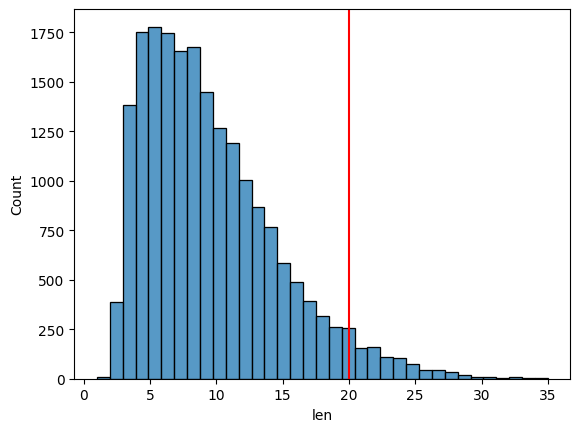

In [16]:
p95 = np.percentile(data['len'], 95)
print('95% 지점', p95)
sns.histplot(x = 'len', data = data, bins = 35)
plt.axvline(p95, color = 'r')
plt.show()

In [17]:
from keras.utils import pad_sequences
max_len = 20
sequences = pad_sequences(data["sequences"],
                            maxlen=max_len,
                            padding='post',
                            truncating='post',
                            value=vocab["<PAD>"])

In [19]:
print(sequences[:10])

[[  50    1  510    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [  31    2  408 2987  431   44   54 1565 1252    0    0    0    0    0    0    0    0    0    0    0]
 [   4 2988 1100  183    1  381  308    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [  78    2  561 4628    6   13 3363    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   2  918    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [  16    2    8  454  207  218   61    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [  16  233 8278   98 8279  748   16 2698 1394   64 1725   38    1    3  298    0    0    0    0    0]
 [   1  342   18 1814  696   91  168  257    0    0    0    0    0    0    0    0    0    0    0    0]
 [5826  122    1 5826 5827   49   46  893 4629    0    0    0    0    0    0    0    0    0    0    0]
 [   1  540    0    0    0    0    0    0    0    0    0    0    0    0  

### (5) x,y 준비

In [20]:
x = np.array(sequences)
y = np.array(data["label"])
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2)
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

## **3. 모델링**

### (1) 모델 구조 설계

In [21]:
class SimpleLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(SimpleLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

### (2) 모델 선언

In [25]:
vocab_size = len(vocab)
embedding_dim = 100
hidden_size = 128
output_size = 6
learning_rate = 0.001

model = SimpleLSTMClassifier(vocab_size, embedding_dim, hidden_size, output_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### (3) 학습

Epoch 1, train loss : 1.580409, val loss : 1.584364
Epoch 2, train loss : 1.565507, val loss : 1.515307
Epoch 3, train loss : 1.023581, val loss : 0.693847
Epoch 4, train loss : 0.395076, val loss : 0.375680
Epoch 5, train loss : 0.178761, val loss : 0.319730
Epoch 6, train loss : 0.105708, val loss : 0.328641
Epoch 7, train loss : 0.069989, val loss : 0.350904
Epoch 8, train loss : 0.054215, val loss : 0.372621
Epoch 9, train loss : 0.041062, val loss : 0.418135
Epoch 10, train loss : 0.036361, val loss : 0.451350


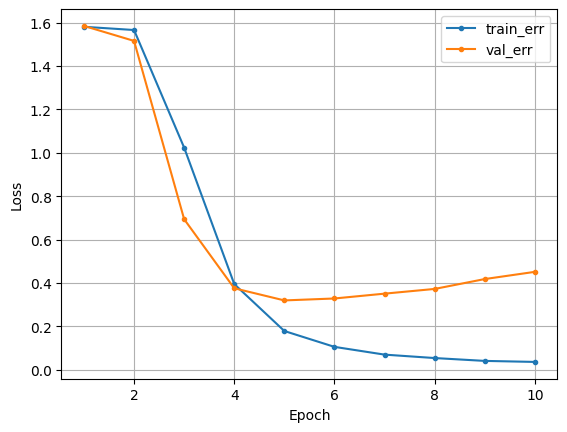

In [26]:
epochs = 10
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

dl_learning_curve(tr_loss_list, val_loss_list)

### (4) 검증평가

In [27]:
# 예측
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)
print(type(pred))
pred = pred.softmax(dim = 1)
pred = np.argmax(pred.cpu().numpy(), axis = 1)

<class 'torch.Tensor'>


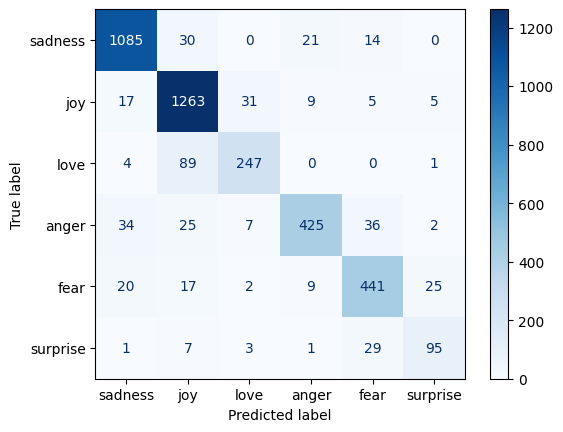

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

     sadness       0.93      0.94      0.94      1150
         joy       0.88      0.95      0.91      1330
        love       0.85      0.72      0.78       341
       anger       0.91      0.80      0.86       529
        fear       0.84      0.86      0.85       514
    surprise       0.74      0.70      0.72       136

    accuracy                           0.89      4000
   macro avg       0.86      0.83      0.84      4000
weighted avg       0.89      0.89      0.89      4000



In [29]:
# confusion matrix 시각화
label_list = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
cm = confusion_matrix(y_val_ts.cpu().numpy(), pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot(cmap="Blues")
plt.show()
print('-'*100)

# classification_report
print(classification_report(y_val_ts.cpu().numpy(), pred, target_names=label_list))